# <p style="text-align: center;"> Spooky Author </p>

In [1]:
from IPython.display import HTML
from IPython.display import Image
Image(url= "http://blog.bookbaby.com/wp-content/uploads/2016/10/Horror-Book-Banner.jpg")

In [2]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# <p style="text-align: center;"> Table of Contents </p>
- ## 1. [Introduction](#Introduction)
   - ### 1.1 [Abstract](#abstract)
   - ### 1.2 [Importing Libraries](#importing_libraries)
   - ### 1.3 [Dataset Summary](#dataset_summary)
   - ### 1.4 [Dataset Cleaning](#dataset_cleaning)
   - ### 1.5 [Exploratory Data Analysis (EDA)](#eda)
       - ### 1.5.1 [Wordcloud](#wordcloud)
       - ### 1.5.2 [Wordcloud with Masking](#wordcloud_with_masking)
- ## 2.0 [Feature Extraction](#FeatureExtraction)
- ## 3.0 [Tf-idf Model](#tfidf)
- ## 4.0 [Naive-Bayes Model](#mnb)
- ## 5.0 [Truncated SVD](#truncsvd)
- ## 6.0 [XGBoost](#xgb)
- ## 7.0 [Markov Model](#markov)
- ## 8. [H2O](#h2o)
   - ### 8.1 [Initializing H2O](#initializing_h2o)
   - ### 8.2 [Connecting H2O](#connecting_h2o)
- ## 9. [Conclusion](#Conclusion)
- ## 10. [Contribution](#Contribution)
- ## 11. [Citation](#Citation)
- ## 12. [License](#License)

# <p style="text-align: center;"> 1.0 Introduction </p> <a id='Introduction'></a>

#   1.1 Abstract  <a id='abstract'></a>
Spooky Author Identification is a Kaggle Competition which ended in December, 2017. The task of this competition was to identify the author of the text. The evaluation metric of this competition is logloss. This kernel will be my attempt on topic modelling and creating a multiclass classifier. I have used various algorithms like Tf-Idf, Naive-Bayes, Truncated SVD, Markov Model and X-Gboost to model the dataset. 


[Back to top](#Introduction)

#   1.2 Importing Libraries  <a id='importing_libraries'></a>
In this step we import a few libraries that are required in our program. Some major libraries that are used are Numpy, Pandas, MatplotLib, Seaborn, Sklearn, XGBoost, NLTK and h2o.

[Back to top](#Introduction)

In [3]:
import h2o
from h2o.automl import H2OAutoML
run_time=333
project ="Assignment-3"
balance_y=False 

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import time

import nltk

from nltk.corpus import stopwords

import spacy
import base64 
from scipy.misc import imread
import codecs
from wordcloud import WordCloud, STOPWORDS,ImageColorGenerator

import string

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes
from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import confusion_matrix,roc_auc_score,log_loss

from astropy.table import Table, Column

seed = 2176


import xgboost as xgb 


import warnings; warnings.simplefilter('ignore')

#   1.3 Dataset Summary  <a id='dataset_summary'></a>
Here we are looking at the top 5 rows of the dataset to view, what type of dataset it is. We also look at the columns which show the various attributes in the dataset. 

[Back to top](#Introduction)

In [4]:
start_time = time.time()
train_df = pd.read_csv("train.csv", encoding="ISO-8859-1")
test_df = pd.read_csv("test.csv")
#train_h2o_df=h2o.H2OFrame(train_df)
#test_h2o_df=h2o.upload_file("test.csv")
end = time.time()
print("Time taken in reading the input files is {}.".format(end - start_time))
train_df.head()

Time taken in reading the input files is 0.13559913635253906.


,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


As we can see there are only 3 columns in the dataset, so there isn't much information that we can work with right now. 
The Fields that we are given here re-

- id - Id of the record
- text - Text - main input data
- author - Author of the given text In train data the author is given for each text for training, and in text we are only given text data and we are expected to predict the author using the given text. 

We need to add a few more columns to do some analysis.


In [5]:
# Explore the dataset 
print("Number of rows in train dataset {} ".format(train_df.shape[0]))
print("Number of rows in test dataset {} ".format(test_df.shape[0]))
print("No duplicates in train data") if train_df.shape[0] == train_df.text.unique().__len__() else print("Oops")
print("No duplicates in test data") if test_df.shape[0] == test_df.text.unique().__len__() else print("Oops")
print("Unique author is data {}.".format(train_df.author.unique()))
print("Number of nulls in the train is {} and text is {}.".format(train_df.isnull().sum().sum(), test_df.isnull().sum().sum()))

Number of rows in train dataset 19579 
Number of rows in test dataset 8392 
No duplicates in train data
No duplicates in test data
Unique author is data ['EAP' 'HPL' 'MWS'].
Number of nulls in the train is 0 and text is 0.


### Checking the frequencies of text for all author in training dataset

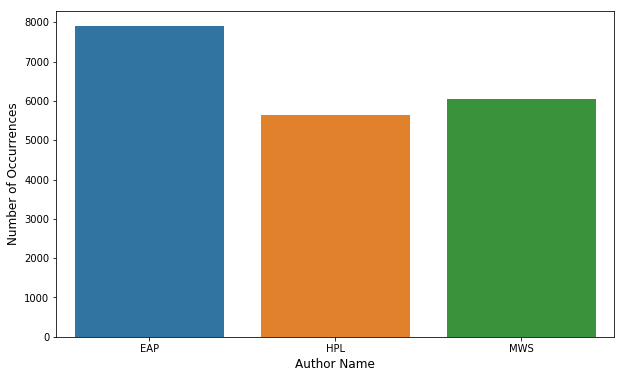

In [6]:
# Checking the frequencies of text for all author in training dataset
author_summary = pd.DataFrame(train_df.groupby('author')['text'].count())
author_summary.reset_index(inplace = True)
plt.figure(figsize=(10,6))
sns.barplot(author_summary.author, author_summary.text)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Author Name', fontsize=12)
plt.show()

#   1.4 Dataset Cleaning  <a id='dataset_cleaning'></a>
Next we will check if there are any missing or Null values in the dataset.

[Back to top](#Introduction)

In [7]:
print("Are there Null Values in the dataset? ")
train_df.isnull().values.any()

Are there Null Values in the dataset? 


False

Great! We don't have any null values in the dataset, so we don't need to do any cleaning in the given dataset!
Let's Move on to the EDA in our dataset.

In [8]:
from IPython.display import HTML
from IPython.display import Image
Image(url= "https://media3.giphy.com/media/3oKIP8lAf1aJTFEeWc/giphy.gif?cid=790b76115ca44fe03439547559cf4a84")

#   1.5 Exploratory Data Analysis <a id='eda'></a>
Now let's move to the fun part! EDA
Exploratory Data Analysis refers to the critical process of performing initial investigations on data so as to discover patterns,to spot anomalies,to test hypothesis and to check assumptions with the help of summary statistics and graphical representations.

It is a good practice to understand the data first and try to gather as many insights from it. EDA is all about making sense of data in hand,before getting them dirty with it.


[Back to top](#Introduction)

In [9]:
# Lets check the avg number of words in text written by each author in a histogram 
def word_count(row):
    """function to calculate the count of words in a given text """
    text = row['text']
    text_splited = text.split(' ')
    word_count = text_splited.__len__()
    return word_count

train_df['word_count'] = ''
train_df['word_count'] = train_df.apply(lambda row: word_count(row), axis =1)
test_df['word_count'] = test_df.apply(lambda row: word_count(row), axis =1)

In [10]:
def base_64(input_image):
    """ Function to convert the image to base64 """
    image = open(input_image, 'rb') #open binary file in read mode 
    image_read = image.read()
    output_base64 = base64.encodestring(image_read)
    return output_base64

In [11]:
Ravens = base_64('Ravens.png')
Cthulhu = base_64('Cthulhu.png')
Frankenstien = base_64('Frankenstien.png')

In [12]:
def codecs_img(input_image,base64_image):
    """Generate the Mask for EAP """
    f1 = open(input_image, "wb")
    f1.write(codecs.decode(base64_image,'base64'))
    f1.close()
    img1 = imread(input_image)
    #img = img1.resize((980,1000))
    #imgplot=plt.imshow(img1)
    #plt.show()
    hcmask=img1
    return hcmask 

In [13]:
hcmask1 = codecs_img('Ravens.png' , Ravens)
hcmask2 = codecs_img('Cthulhu.png' , Cthulhu)
hcmask3 = codecs_img('Frankenstien.png' , Frankenstien)

## 1.5.1 Generating WordCloud without a Mask <a id='#wordcloud'></a>
Word clouds (also known as text clouds or tag clouds) work in a simple way: the more a specific word appears in a source of textual data (such as a speech, blog post, or database), the bigger and bolder it appears in the word cloud.

Word clouds show you what is emphasized in your text. For example, if you’re a fiction writer, you can instantly see what words are used more frequently in your current scene. This can help you spot words that perhaps you’ve over-used or to make sure you’re focusing on the most important characters or other key areas in your scene.

[Back to top](#Introduction)

(-0.5, 399.5, 199.5, -0.5)

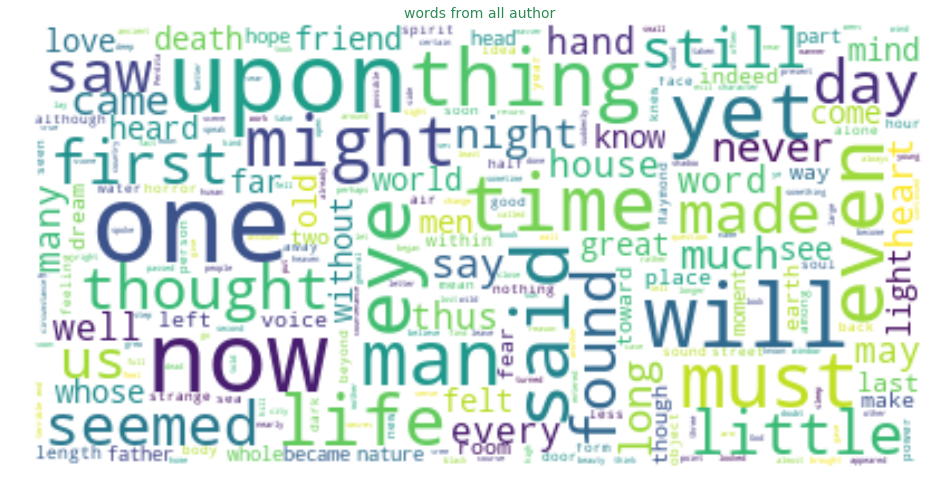

In [14]:
eap = train_df[train_df.author=="EAP"]["text"].values
hpl = train_df[train_df.author=="HPL"]["text"].values
mws = train_df[train_df.author=="MWS"]["text"].values

wc = WordCloud(background_color="white", max_words=5000, 
               stopwords=STOPWORDS, max_font_size= 50)
# generate word cloud
wc.generate(" ".join(train_df.text.values))

# show
plt.figure(figsize=(16,13))
plt.imshow(wc, interpolation='bilinear')
plt.title("words from all author", fontsize=14,color='seagreen')
plt.axis("off")

In [15]:
def generate_wordcloud(words, mask):
    """ Generating Word Clouds """
    word_cloud = WordCloud(width = 512, height = 512, background_color='white', stopwords=STOPWORDS, mask=mask, max_font_size= 45).generate(" ".join(words))
    plt.figure(figsize=(10,9))
    image_colors = ImageColorGenerator(mask)
    plt.imshow(word_cloud.recolor(color_func=image_colors), interpolation='bilinear') # interpolation(helps in masking)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()
    

## 1.5.2 Generating WordCloud with a Mask <a id='#wordcloud_with_masking'></a>

I have learned from anistropic that masked wordclouds look much better than nornmal one, So, I am also making wordclouds with different masks. Idea and embeddings are taken from anistropic's notebook, thanks anistropic.

[Back to top](#Introduction)

### WordCloud for Edgar Allen Poe (Raven)
We chose Raven as a Mask for EAP because he's most known for his work The Raven.

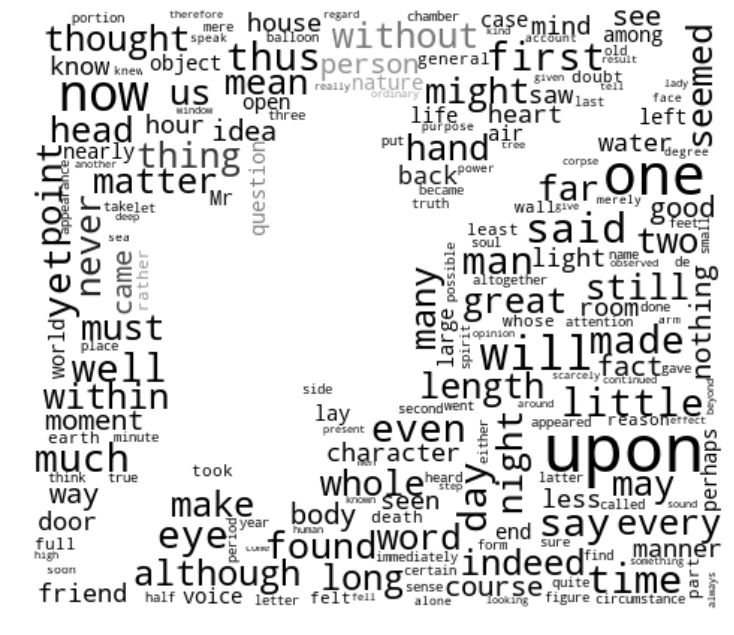

In [16]:
generate_wordcloud(eap,hcmask1)

### WordCloud for H.P. Lovecraft (Cthulhu)
We chose Cthulhu for HPL as it is a fictional cosmic entity created by writer H. P. Lovecraft and first introduced in the short story "The Call of Cthulhu", published in the American pulp magazine Weird Tales in 1928.

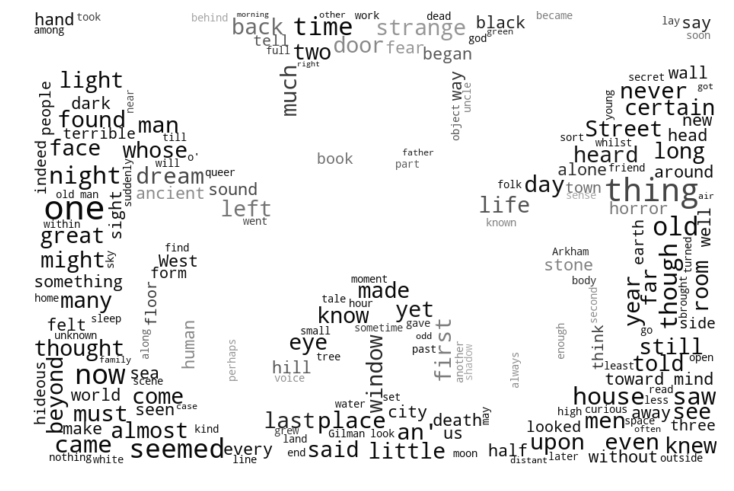

In [17]:
generate_wordcloud(hpl,hcmask2)

### WordCloud for Mary West Shelly (Frankenstien)
We chose Frankestien for MWS as Frankenstein; or, The Modern Prometheus is a novel written by English author Mary Shelley that tells the story of Victor Frankenstein, a young scientist who creates a hideous, sapient creature in an unorthodox scientific experiment.

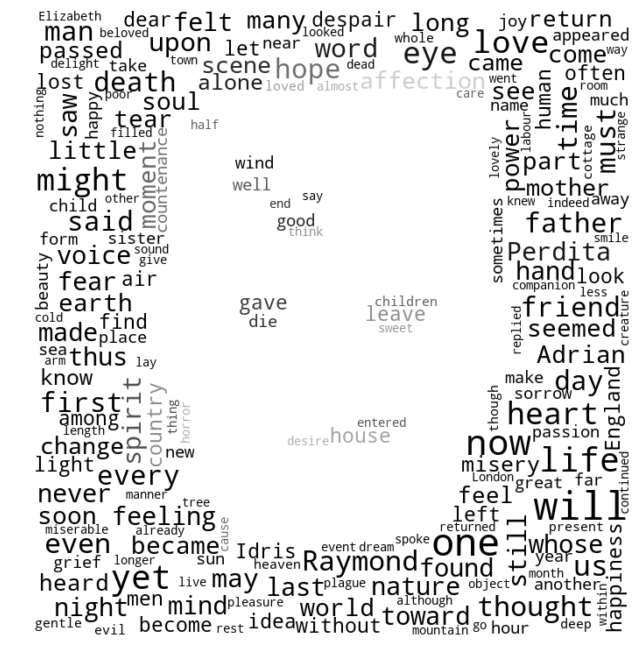

In [18]:
generate_wordcloud(mws,hcmask3)

# <p style="text-align: center;"> 2.0 Feature Extraction </p> <a id='FeatureExtraction'></a>
## Features corresponding to characteristics of different author's writting style
Here my assuption is that each text that's been given is a paragraph in one of the books of corresponding author. Based on that assumption if we try and we can see if there is any pattern in author's writting style and based on that we can classify which text belong to which author. As of now, I am thinking about following features that can be put in this category. they are -

- word_count - The count of words in given text
- unique_words_fraction - Fraction of words that are unique in a given text
- stop_words - Fraction of stopwords present in a given text - Number of stopwords/Total words
- punctuations - Fraction of punctuation present in a given text - Number of puctuations/Total words
- fract_Nouns - Fraction of Nuons
- fract_adj - Fraction of Adjectives present in a text

As of now I can think of these aforesaid features, will update this list of features if I extract any other features than mentioned features. Lets define function for features releted to author's characteristics and then run those function for final feature extraction.

#### Note:
 Here for some or most of the features I have used fraction and not the number as my person experience of document classification using manualluy designed features says that it make more sense to use fraction as if one text is larger thgan the author the number will mislead you while fraction will cover the pith about author's characteristics.
 
[Back to top](#Introduction)

In [19]:
#list of unique word fraction
def unique_word_fraction(row):
    """function to calculate the fraction of unique words on total words of the text"""
    text = row['text']
    text_splited = text.split(' ')
    text_splited = [''.join(c for c in s if c not in string.punctuation) for s in text_splited]
    text_splited = [s for s in text_splited if s]
    word_count = text_splited.__len__()
    unique_count = list(set(text_splited)).__len__()
    return (unique_count/word_count)


In [20]:
#count of stopwords in the text
eng_stopwords = set(stopwords.words("english"))
def stopwords_count(row):
    """ Number of stopwords fraction in a text"""
    text = row['text'].lower()
    text_splited = text.split(' ')
    text_splited = [''.join(c for c in s if c not in string.punctuation) for s in text_splited]
    text_splited = [s for s in text_splited if s]
    word_count = text_splited.__len__()
    stopwords_count = len([w for w in text_splited if w in eng_stopwords])
    return (stopwords_count/word_count)

In [21]:
#fraction of punctuations in the text
def punctuations_fraction(row):
    """functiopn to claculate the fraction of punctuations over total number of characters for a given text """
    text = row['text']
    char_count = len(text)
    punctuation_count = len([c for c in text if c in string.punctuation])
    return (punctuation_count/char_count)

In [22]:
#charachter count
def char_count(row):
    """function to return number of chracters """
    return len(row['text'])

In [23]:
#fraction of nouns
def fraction_noun(row):
    """function to give us fraction of noun over total words """
    text = row['text']
    text_splited = text.split(' ')
    text_splited = [''.join(c for c in s if c not in string.punctuation) for s in text_splited]
    text_splited = [s for s in text_splited if s]
    word_count = text_splited.__len__()
    pos_list = nltk.pos_tag(text_splited)
    noun_count = len([w for w in pos_list if w[1] in ('NN','NNP','NNPS','NNS')])
    return (noun_count/word_count)

In [24]:
#fraction of Adjectives
def fraction_adj(row):
    """function to give us fraction of adjectives over total words in given text"""
    text = row['text']
    text_splited = text.split(' ')
    text_splited = [''.join(c for c in s if c not in string.punctuation) for s in text_splited]
    text_splited = [s for s in text_splited if s]
    word_count = text_splited.__len__()
    pos_list = nltk.pos_tag(text_splited)
    adj_count = len([w for w in pos_list if w[1] in ('JJ','JJR','JJS')])
    return (adj_count/word_count)

In [25]:
#fraction of Verbs
def fraction_verbs(row):
    """function to give us fraction of verbs over total words in given text"""
    text = row['text']
    text_splited = text.split(' ')
    text_splited = [''.join(c for c in s if c not in string.punctuation) for s in text_splited]
    text_splited = [s for s in text_splited if s]
    word_count = text_splited.__len__()
    pos_list = nltk.pos_tag(text_splited)
    verbs_count = len([w for w in pos_list if w[1] in ('VB','VBD','VBG','VBN','VBP','VBZ')])
    return (verbs_count/word_count)

### Applying the Feature Extraction on our Data

Applying functions-defined above-to extract features based on characteristics of author's writing style on train data...

In [26]:
train_df['unique_word_fraction'] = train_df.apply(lambda row: unique_word_fraction(row), axis =1)
train_df['stopwords_count'] = train_df.apply(lambda row: stopwords_count(row), axis =1)
train_df['punctuations_fraction'] = train_df.apply(lambda row: punctuations_fraction(row), axis =1)
train_df['char_count'] = train_df.apply(lambda row: char_count(row), axis =1)
train_df['fraction_noun'] = train_df.apply(lambda row: fraction_noun(row), axis =1)
train_df['fraction_adj'] = train_df.apply(lambda row: fraction_adj(row), axis =1)
train_df['fraction_verbs'] = train_df.apply(lambda row: fraction_verbs(row), axis =1)
train_df.head()

,id,text,author,word_count,unique_word_fraction,stopwords_count,punctuations_fraction,char_count,fraction_noun,fraction_adj,fraction_verbs
0,id26305,"This process, however, afforded me no means of...",EAP,41,0.853659,0.487805,0.030303,231,0.243902,0.048780,0.146341
1,id17569,It never once occurred to me that the fumbling...,HPL,14,1.000000,0.571429,0.014085,71,0.142857,0.071429,0.142857
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,36,0.888889,0.472222,0.025000,200,0.277778,0.138889,0.111111
3,id27763,How lovely is spring As we looked from Windsor...,MWS,34,0.941176,0.382353,0.019417,206,0.294118,0.176471,0.147059
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,27,0.925926,0.407407,0.022989,174,0.222222,0.037037,0.222222


Now that we have a few numerical columns, we can perform analysis on the same

Applying functions-defined above-to extract features based on characteristics of author's writing style on test data

In [27]:
test_df['unique_word_fraction'] = test_df.apply(lambda row: unique_word_fraction(row), axis =1)
test_df['stopwords_count'] = test_df.apply(lambda row: stopwords_count(row), axis =1)
test_df['punctuations_fraction'] = test_df.apply(lambda row: punctuations_fraction(row), axis =1)
test_df['char_count'] = test_df.apply(lambda row: char_count(row), axis =1)
test_df['fraction_noun'] = test_df.apply(lambda row: fraction_noun(row), axis =1)
test_df['fraction_adj'] = test_df.apply(lambda row: fraction_adj(row), axis =1)
test_df['fraction_verbs'] = test_df.apply(lambda row: fraction_verbs(row), axis =1)
test_df.head()

,id,text,word_count,unique_word_fraction,stopwords_count,punctuations_fraction,char_count,fraction_noun,fraction_adj,fraction_verbs
0,id02310,"Still, as I urged our leaving Ireland with suc...",19,1.000000,0.473684,0.027273,110,0.210526,0.105263,0.210526
1,id24541,"If a fire wanted fanning, it could readily be ...",62,0.790323,0.548387,0.021212,330,0.258065,0.032258,0.161290
2,id00134,And when they had broken down the frail door t...,33,0.909091,0.484848,0.015873,189,0.212121,0.121212,0.151515
3,id27757,While I was thinking how I should possibly man...,41,0.829268,0.512195,0.022422,223,0.170732,0.048780,0.170732
4,id04081,I am not sure to what limit his knowledge may ...,11,1.000000,0.545455,0.018868,53,0.090909,0.090909,0.272727



# <p style="text-align: center;"> 3.0 Tf-idf Model </p> <a id='tfidf'></a>
Tf-idf stands for term frequency-inverse document frequency. The tf-idf weight is a weight often used in information retrieval and text mining. This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. 

#### How to Compute:

Typically, the tf-idf weight is composed by two terms: the first computes the normalized Term Frequency (TF), aka. the number of times a word appears in a document, divided by the total number of words in that document; the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

TF: Term Frequency, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization: 


\begin{equation*}
TF(t) =\frac {(Number\: of\: times\: term\: t\: appears\: in\: a\: document\:)}{(Total\: number\: of\: terms\: in\: the\: document\:)}
\end{equation*}

IDF: Inverse Document Frequency, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following: 

\begin{equation*}
IDF(t) = log_e \frac{(Total\: number\: of\: documents\:)}{(Number\: of\: documents\: with\: term\: t\: in\: it\:)}
\end{equation*}

[Back to top](#Introduction)

In [28]:
start = time.time()
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
full_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())
end = time.time()
print("Time taken in tf-idf is {}.".format(end-start))

cols_to_drop = ['id', 'text']
train_X = train_df.drop(cols_to_drop+['author'], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)
author_mapping_dict = {'EAP':0, 'HPL':1, 'MWS':2}
train_y = train_df['author'].map(author_mapping_dict)

Time taken in tf-idf is 7.237626791000366.


# <p style="text-align: center;"> 4.0 Multinomial Naive Bayes </p> <a id='mnb'></a>
Naive Bayes is a family of probabilistic algorithms that take advantage of probability theory and Bayes’ Theorem to predict the tag of a text (like a piece of news or a customer review). We need to transform the probability we want to calculate into something that can be calculated using word frequencies. For this, we use some basic properties of probabilities, and Bayes’ Theorem. Naive-Bayes is used for multinomial and gausian distributions.

\begin{equation*}
P(A|B)= \frac {P(B|A) \times P(A)}{P(B)}
\end{equation*}

Why Naive? We assume that every word in a sentence is independent of the other ones. This means that we’re no longer looking at entire sentences, but rather at individual words.

[Back to top](#Introduction)

In [29]:
# this function is taken from SRK's notebook
def runMNB(train_X, train_y, test_X, test_y, test_X2):
    model = naive_bayes.MultinomialNB()
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)
    pred_test_y2 = model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_cvec_eap"] = pred_train[:,0]
train_df["nb_cvec_hpl"] = pred_train[:,1]
train_df["nb_cvec_mws"] = pred_train[:,2]
test_df["nb_cvec_eap"] = pred_full_test[:,0]
test_df["nb_cvec_hpl"] = pred_full_test[:,1]
test_df["nb_cvec_mws"] = pred_full_test[:,2]

Mean cv score :  0.8421559083173509


# <p style="text-align: center;"> 5.0 Truncated SVD </p> <a id='truncsvd'></a>

Dimensionality reduction using truncated SVD.

This transformer performs linear dimensionality reduction by means of truncated singular value decomposition (SVD). Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. This means it can work with scipy.sparse matrices efficiently.
SVD is not used to normalize the data, but to get rid of redundant data, that is, for dimensionality reduction. The eigenvalues in SVD help you determine what variables are most informative, and which ones you can do without.

When we form SVD over our training data (call it matrix A), to obtain U, S and V*. Then set to zero all values of S less than a certain arbitrary threshold (e.g. 0.1), call this new matrix S'. Then obtain A' = US'V* and use A' as your new training data. Some of your features are now set to zero and can be removed, sometimes without any performance penalty (depending on your data and the threshold chosen). This is called truncated SVD.

[Back to top](#Introduction)

In [30]:
### Fit transform the count vectorizer ###
tfidf_vec = CountVectorizer(stop_words='english', ngram_range=(1,3))
tfidf_vec.fit(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_cvec_eap"] = pred_train[:,0]
train_df["nb_cvec_hpl"] = pred_train[:,1]
train_df["nb_cvec_mws"] = pred_train[:,2]
test_df["nb_cvec_eap"] = pred_full_test[:,0]
test_df["nb_cvec_hpl"] = pred_full_test[:,1]
test_df["nb_cvec_mws"] = pred_full_test[:,2]

Mean cv score :  0.45083470808591003


In [31]:
start = time.time()
n_comp = 400
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
    
train_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd
end = time.time()
print("Time taken in tf-idf is {}.".format(end-start))

Time taken in tf-idf is 113.63476777076721.


In [32]:
#character based tfidf
start = time.time()
tfidf_vec = TfidfVectorizer(ngram_range=(1,5), analyzer='char')
full_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())
n_comp = 40
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))   
train_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd
end = time.time()
print("Time taken in tf-idf is {}.".format(end-start))

Time taken in tf-idf is 37.305198669433594.


# <p style="text-align: center;"> 6.0 XGBoost </p> <a id='xgb'></a>


XGBoost stands for eXtreme Gradient Boosting.XGBoost is an implementation of gradient boosted decision trees designed for speed and performance. It is both a linear model solver and a tree learning algorithm. It does a parallel computation on a single machihne , and supports various objective functions including regression, classification and ranking. 
> Two reasons to use XGBoost are also the two goals of the project: 

> 1. Execution Speed. 

> 2. Model Performance.

The XGBoost library implements the gradient boosting decision tree algorithm.

This algorithm goes by lots of different names such as gradient boosting, multiple additive regression trees, stochastic gradient boosting or gradient boosting machines.

Boosting is an ensemble technique where new models are added to correct the errors made by existing models. Models are added sequentially until no further improvements can be made. A popular example is the AdaBoost algorithm that weights data points that are hard to predict.

Gradient boosting is an approach where new models are created that predict the residuals or errors of prior models and then added together to make the final prediction. It is called gradient boosting because it uses a gradient descent algorithm to minimize the loss when adding new models.

This approach supports both regression and classification predictive modeling problems.

Before running XGBoost, we must set three types of parameters: general parameters, booster parameters and task parameters.

>General parameters relate to which booster we are using to do boosting, commonly tree or linear model

>Booster parameters depend on which booster you have chosen

>Learning task parameters decide on the learning scenario. For example, regression tasks may use different parameters with ranking tasks.

>Command line parameters relate to behavior of CLI version of XGBoost.

XGBoost Parameters 
-    'n_trees': 500,   #general parameter used as booster
-    'eta': 0.005,     #Booster Parameter used as learning_rate, step shrinkage reduces overfitting and eta shrinks the feature weights to make the boosting process more conservative.
-    'max_depth': 4,   #Booster Parameter Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit
-    'subsample': 0.95, #Booster Parameter Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. 
-    'objective': 'reg:linear', #Learning Parameter Specify the learning task and the corresponding learning objective
-    'eval_metric': 'rmse', #Learning Parameter Evaluation metrics for validation data, a default metric will be assigned according to objective , user can add multiple metrics
-    'base_score': mean_Y, # Learning Parameter The initial prediction score of all instances, global bias base prediction = mean(target)
-    'silent': 1    #silent [default=0] [Deprecated] Deprecated. Verbosity of printing messages.

[Back to top](#Introduction)


### Implementing XGBoost Without Markov

In [33]:
val_df = train_df.sample(frac=0.2, replace=False)
trn_df = train_df.drop(val_df.index)
author_mapping_dict = {'EAP':0, 'HPL':1, 'MWS':2}
trn_df['author'] = trn_df['author'].astype('category')
val_df['author'] = val_df['author'].astype('category')
cat_columns = trn_df.select_dtypes(['category']).columns
trn_df[cat_columns] = trn_df[cat_columns].apply(lambda x: x.cat.codes)
val_df[cat_columns]=val_df[cat_columns].apply(lambda x: x.cat.codes)
#trn_y = trn_df['author'].map(author_mapping_dict)
#val_y = val_df['author'].map(author_mapping_dict)
cols_drop = ['id', 'text']
trn_X = trn_df.drop(cols_drop+['author'], axis=1)
val_X = val_df.drop(cols_drop+['author'], axis=1)
test_X = test_df.drop(cols_drop, axis=1)


In [34]:
Xtr = trn_X.values
Xv = val_X.values
ytr = trn_df['author']
yv = val_df['author']
dtrain = xgb.DMatrix(Xtr, label=ytr)
dvalid = xgb.DMatrix(Xv, label=yv)
dtest = xgb.DMatrix(test_X.values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

start = time.time()
xgb_par = {'min_child_weight': 1, 'eta': 0.1, 'colsample_bytree': 0.7, 'max_depth': 3,
            'subsample': 0.8, 'lambda': 2.0, 'nthread': -1, 'silent': 1,
            'eval_metric': "mlogloss", 'objective': 'multi:softprob', 'num_class': 3}

model_1 = xgb.train(xgb_par, dtrain, 1000, watchlist, early_stopping_rounds=50, maximize=False, verbose_eval=40)
print('Modeling RMSLE %.5f' % model_1.best_score)
end = time.time()
print("Time taken in training is {}.".format(end - start))

[0]	train-mlogloss:1.01965	valid-mlogloss:1.02112
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 50 rounds.
[40]	train-mlogloss:0.382601	valid-mlogloss:0.421437
[80]	train-mlogloss:0.333404	valid-mlogloss:0.397475
[120]	train-mlogloss:0.301379	valid-mlogloss:0.39029
[160]	train-mlogloss:0.275075	valid-mlogloss:0.387978
[200]	train-mlogloss:0.252663	valid-mlogloss:0.386902
[240]	train-mlogloss:0.233169	valid-mlogloss:0.385837
[280]	train-mlogloss:0.215685	valid-mlogloss:0.385055
[320]	train-mlogloss:0.20003	valid-mlogloss:0.386203
Stopping. Best iteration:
[287]	train-mlogloss:0.213017	valid-mlogloss:0.384951

Modeling RMSLE 0.38495
Time taken in training is 196.26227235794067.


In [35]:
yvalid = model_1.predict(dvalid)
ytest = model_1.predict(dtest)

In [36]:
if test_df.shape[0] == ytest.shape[0]:
    print('Test shape OK.') 
test_id = test_df['id'].values
out_df = pd.DataFrame(ytest)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', test_id)
out_df=out_df.rename(columns={'id':'id','EAP':'EAP_SVD','HPL':'HPL_SVD','MWS':'MWS_SVD'})
out_df.head()

Test shape OK.


,id,EAP_SVD,HPL_SVD,MWS_SVD
0,id02310,0.026821,0.012318,0.960861
1,id24541,0.998021,0.000948,0.001032
2,id00134,0.118353,0.874323,0.007324
3,id27757,0.744240,0.241992,0.013768
4,id04081,0.914166,0.068771,0.017063


## <p style="text-align: center;"> 7.0 Markov Model </p> <a id='markov'></a>

In probability theory, a Markov model is a stochastic model used to model randomly changing systems where it is assumed that future states depend only on the current state not on the events that occurred before it (that is, it assumes the Markov property). 

For Markov Models we need a list of Tokens (words) and Keys (unique words). By looking at the distribution of keys we can analyize the frequncy of keys. This helps us assign weight to the keys(more the frequency, more the weight). And since in the markov model future states depend only on the current state not on the events that occurred before it. One way to think about it is you have a window that only shows the current state (or in our case a single token) and then you have to determine what the next token is based on that small window! 

We generally set the window size depending on the size of the data. If there is a bigger window in a smaller data set it is unlikely that there will be large unique distributions for the possible outcomes from one window therefore it could only recreate the same sentences.


[Back to top](#Introduction)

We take the famous quote by Dr. Seuss as an example to show how Markov Model works.

## <p style="text-align: center;"> “One fish two fish red fish blue fish.” </p> 

In [37]:
from IPython.display import HTML
from IPython.display import Image
Image(url="https://cdn-images-1.medium.com/max/1600/1*MbHRwYNA8F29hzes8EPHiQ.gif")

In [38]:
val_df = train_df.sample(frac=0.2, replace=False)
trn_df = train_df.drop(val_df.index)
print(trn_df.shape[0])
print(val_df.shape[0])
print(train_df.shape[0])
trn_df.head()

15663
3916
19579


,id,text,author,word_count,unique_word_fraction,stopwords_count,punctuations_fraction,char_count,fraction_noun,fraction_adj,...,svd_char_30,svd_char_31,svd_char_32,svd_char_33,svd_char_34,svd_char_35,svd_char_36,svd_char_37,svd_char_38,svd_char_39
1,id17569,It never once occurred to me that the fumbling...,HPL,14,1.000000,0.571429,0.014085,71,0.142857,0.071429,...,-0.002096,-0.059580,-0.041699,-0.009041,0.024729,0.041637,-0.053297,0.025247,0.041670,0.085482
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,36,0.888889,0.472222,0.025000,200,0.277778,0.138889,...,-0.009090,0.003837,0.015726,0.013425,0.004661,0.014792,0.013078,-0.039694,0.015022,-0.044003
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,27,0.925926,0.407407,0.022989,174,0.222222,0.037037,...,0.027235,-0.018083,0.054464,0.029740,0.021226,0.013636,0.009440,0.008827,-0.044059,0.002839
5,id22965,"A youth passed in solitude, my best years spen...",MWS,83,0.795181,0.518072,0.012821,468,0.216867,0.072289,...,-0.003523,0.005566,0.006944,-0.003487,0.017539,0.017053,0.005778,-0.007669,0.009497,-0.007681
6,id09674,"The astronomer, perhaps, at this point, took r...",EAP,21,1.000000,0.428571,0.039062,128,0.285714,0.095238,...,0.005744,0.001004,0.013077,0.039769,-0.011742,-0.006310,0.014158,0.018455,-0.036414,-0.009422


In [39]:
import random

class Dictogram(dict):
    def __init__(self, iterable=None):
        """Initialize this histogram as a new dict; update with given items"""
        super(Dictogram, self).__init__()
        self.types = 0  # the number of distinct item types in this histogram
        self.tokens = 0  # the total count of all item tokens in this histogram
        if iterable:
            self.update(iterable)

    def update(self, iterable):
        """Update this histogram with the items in the given iterable"""
        for item in iterable:
            if item in self:
                self[item] += 1
                self.tokens += 1
            else:
                self[item] = 1
                self.types += 1
                self.tokens += 1

    def count(self, item):
        """Return the count of the given item in this histogram, or 0"""
        if item in self:
            return self[item]
        return 0
    
    def return_random_word(self):
        # Another way:  Should test: random.choice(histogram.keys())
        random_key = random.sample(self, 1)
        return random_key[0]

    def return_weighted_random_word(self):
        # Step 1: Generate random number between 0 and total count - 1
        random_int = random.randint(0, self.tokens-1)
        index = 0
        list_of_keys = self.keys()
        # print 'the random index is:', random_int
        for i in range(0, self.types):
            index += self[list_of_keys[i]]
            # print index
            if(index > random_int):
                # print list_of_keys[i]
                return list_of_keys[i]

In [40]:
# markov chain based features, 3 words memory 
def make_higher_order_markov_model(order, data):
    markov_model = dict()

    for i in range(0, len(data)-order):
        # Create the window
        window = tuple(data[i: i+order])
        # Add to the dictionary
        if window in markov_model:
            # We have to just append to the existing Dictogram
            markov_model[window].update([data[i+order]])
        else:
            markov_model[window] = Dictogram([data[i+order]])
    return markov_model

In [41]:
#print(trn_df.loc[train_df['author']=='EAP'].shape[0])
def tokenixed_list(row):
    """function to calculate the fraction of unique words on total words of the text"""
    text = row['text']
    text_splited = text.split(' ')
    text_splited = [''.join(c for c in s if c not in string.punctuation) for s in text_splited]
    text_splited = [s for s in text_splited if s]
    return (text_splited)
trn_df['splited_text'] = trn_df.apply(lambda row: tokenixed_list(row), axis =1)

In [42]:
eap = trn_df.loc[trn_df['author']=='EAP']['splited_text'].values
flat_eap = []
eap_flat = [flat_eap.extend(x) for x in eap]
flat_eap.__len__()
eap_MM = make_higher_order_markov_model(3, flat_eap)

In [43]:
hpl = trn_df.loc[trn_df['author']=='HPL']['splited_text'].values
flat_hpl = []
hpl_flat = [flat_hpl.extend(x) for x in hpl]
flat_hpl.__len__()
hpl_MM = make_higher_order_markov_model(3, flat_hpl)

In [44]:
ms = trn_df.loc[trn_df['author']=='MWS']['splited_text'].values
flat_ms = []
ms_flat = [flat_ms.extend(x) for x in ms]
flat_ms.__len__()
ms_MM = make_higher_order_markov_model(3, flat_ms)

In [52]:
#probablity calculation using markov chain
#print(eap_MM[('no', 'means', 'of')])
#print(sum([x for x in eap_MM[('no', 'means', 'of')].values()]))
def spit_out_prob(tupl , word , mm1= eap_MM, mm2 = hpl_MM, mm3 = ms_MM):
    """function to spit out a prob of a word given a tuple and a word and a markov model"""
    """fix this function, its working but not calculating probabilities, but providing
    some confidance index, greater than confidance index is, larger is the prob"""
    try:
        a = mm1[tupl][word]
    except:
        a = 0 
    try:
        b = mm2[tupl][word]
    except:
        b = 0
    try:
        c = mm3[tupl][word]
    except:
        c = 0
    try:
        prob_word = a/(a+b+c)#(sum([x for x in mm[tupl].values()]))
        return (prob_word)
    except:
        return (0) #earlier it was 1
    
def make_tupl(sentence =trn_df.loc[train_df['author']=='EAP']['splited_text'], n=3):
    """function to make tuples of n size given a sentence and n"""
    list_of_tuple = []
    word_1 = []
    for i in list(range(sentence.__len__()-3)):
        tuple_1 = (sentence[i], sentence[i+1], sentence[i+2])
        list_of_tuple.append(tuple_1)
        word_1.append(sentence[i+3])
    return (list_of_tuple, word_1)


def sent_to_prob_eap(sentence, mm1 = eap_MM, p_eap =1/3, mm2 = hpl_MM, mm3 = ms_MM):
    """function to get the markov model to give prob of a author given a sentence """
    list_of_tuples = make_tupl(sentence, n =3)[0]
    words = make_tupl(sentence, n =3)[1]
    #print(list_of_tuples, words)
    #p = p_eap 
    p=0
    for i in list(range(words.__len__())):
        #print(list_of_tuples[i], words[i])
        p = p+spit_out_prob(list_of_tuples[i], words[i], mm1 =eap_MM, mm2 =hpl_MM, mm3 =ms_MM)
    return(p)

def sent_to_prob_hpl(sentence, mm2 = hpl_MM, p_hpl =1/3, mm1 = eap_MM, mm3 = ms_MM):
    """function to get the markov model to give prob of a author given a sentence """
    list_of_tuples = make_tupl(sentence, n =3)[0]
    words = make_tupl(sentence, n =3)[1]
    #print(list_of_tuples, words)
    #p = p_hpl 
    p = 0
    for i in list(range(words.__len__())):
        #print(list_of_tuples[i], words[i])
        p = p+spit_out_prob(list_of_tuples[i], words[i], mm1 =hpl_MM, mm2=eap_MM, mm3=ms_MM)
    return(p)

def sent_to_prob_ms(sentence, mm3 = ms_MM, p_ms =1/3, mm2 = hpl_MM, mm1 = eap_MM):
    """function to get the markov model to give prob of a author given a sentence """
    list_of_tuples = make_tupl(sentence, n =3)[0]
    words = make_tupl(sentence, n =3)[1]
    #print(list_of_tuples, words)
    #p = p_ms 
    p = 0
    for i in list(range(words.__len__())):
        #print(list_of_tuples[i], words[i])
        p = p+spit_out_prob(list_of_tuples[i], words[i], ms_MM, hpl_MM, eap_MM)
    return(p)

In [53]:
# calculating markov chain based features
trn_df['EAP_markov_3'] = trn_df['splited_text'].apply(lambda row: sent_to_prob_eap(sentence =row))
trn_df['HPL_markov_3'] = trn_df['splited_text'].apply(lambda row: sent_to_prob_hpl(sentence = row))
trn_df['MWS_markov_3'] = trn_df['splited_text'].apply(lambda row: sent_to_prob_ms(sentence = row))
trn_df[['MWS_markov_3', 'EAP_markov_3', 'HPL_markov_3', 'author']].head()
del trn_df['splited_text']

In [54]:
val_df['splited_text'] = val_df.apply(lambda row: tokenixed_list(row), axis =1)
val_df['EAP_markov_3'] = val_df['splited_text'].apply(lambda row: sent_to_prob_eap(sentence =row))
val_df['HPL_markov_3'] = val_df['splited_text'].apply(lambda row: sent_to_prob_hpl(sentence = row))
val_df['MWS_markov_3'] = val_df['splited_text'].apply(lambda row: sent_to_prob_ms(sentence = row))
val_df1 = val_df[['MWS_markov_3', 'EAP_markov_3', 'HPL_markov_3','author']].copy()
del val_df['splited_text']

In [55]:
test_df['splited_text'] = test_df.apply(lambda row: tokenixed_list(row), axis =1)
test_df['EAP_markov_3'] = test_df['splited_text'].apply(lambda row: sent_to_prob_eap(sentence =row))
test_df['HPL_markov_3'] = test_df['splited_text'].apply(lambda row: sent_to_prob_hpl(sentence = row))
test_df['MWS_markov_3'] = test_df['splited_text'].apply(lambda row: sent_to_prob_ms(sentence = row))
test_df1 = test_df[['MWS_markov_3', 'EAP_markov_3', 'HPL_markov_3']].copy()
del test_df['splited_text']



### Linear Combination

In [56]:
author_mapping_dict = {'EAP':0, 'HPL':1, 'MWS':2}
trn_y = trn_df['author'].map(author_mapping_dict)
val_y = val_df['author'].map(author_mapping_dict)
cols_drop = ['id', 'text','MWS_markov_3', 'EAP_markov_3', 'HPL_markov_3']
trn_X = trn_df.drop(cols_drop+['author'], axis=1)
val_X = val_df.drop(cols_drop+['author'], axis=1)
test_X = test_df.drop(cols_drop, axis=1)

In [57]:
print(52*'-')
print("shape of train val is {} and {}, test is {}".format(trn_X.shape[1], val_X.shape[1], test_X.shape[1]))
print(52*'-')

----------------------------------------------------
shape of train val is 451 and 451, test is 451
----------------------------------------------------


In [58]:
Xtr = trn_X.values
Xv = val_X.values
ytr = trn_y
yv = val_y
dtrain = xgb.DMatrix(Xtr, label=ytr)
dvalid = xgb.DMatrix(Xv, label=yv)
dtest = xgb.DMatrix(test_X.values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

start = time.time()
xgb_par = {'min_child_weight': 1, 'eta': 0.1, 'colsample_bytree': 0.7, 'max_depth': 3,
            'subsample': 0.8, 'lambda': 2.0, 'nthread': -1, 'silent': 1,
            'eval_metric': "mlogloss", 'objective': 'multi:softprob', 'num_class': 3}

model_1 = xgb.train(xgb_par, dtrain, 1000, watchlist, early_stopping_rounds=50, maximize=False, verbose_eval=40)
print('Modeling RMSLE %.5f' % model_1.best_score)
end = time.time()
print("Time taken in training is {}.".format(end - start))

[0]	train-mlogloss:1.01984	valid-mlogloss:1.02129
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 50 rounds.
[40]	train-mlogloss:0.386061	valid-mlogloss:0.412051
[80]	train-mlogloss:0.338406	valid-mlogloss:0.388176
[120]	train-mlogloss:0.305568	valid-mlogloss:0.380299
[160]	train-mlogloss:0.280218	valid-mlogloss:0.374276
[200]	train-mlogloss:0.257988	valid-mlogloss:0.372147
[240]	train-mlogloss:0.23815	valid-mlogloss:0.371802
[280]	train-mlogloss:0.2208	valid-mlogloss:0.371806
Stopping. Best iteration:
[266]	train-mlogloss:0.226474	valid-mlogloss:0.371198

Modeling RMSLE 0.37120
Time taken in training is 192.382244348526.


In [59]:
print(test_X.shape, trn_X.shape)

(8392, 451) (15663, 451)


In [60]:
start = time.time()
yvalid = model_1.predict(dvalid)
ytest = model_1.predict(dtest)
end = time.time()
print("Time taken in prediction is {}.".format(end - start))

Time taken in prediction is 0.2663257122039795.


In [61]:
val_df1.head()
val_df2 = pd.DataFrame(yvalid)
val_df2.head()
val_df2.columns = ['EAP', 'HPL', 'MWS']
val_df2.head()
val_df1.reset_index(inplace = True, drop =True)
val_df1.head()

,MWS_markov_3,EAP_markov_3,HPL_markov_3,author
0,1.8,1.2,0.0,EAP
1,0.0,2.0,0.0,EAP
2,0.0,0.0,0.0,EAP
3,0.0,0.0,0.0,EAP
4,0.0,0.0,0.0,MWS


In [62]:
test_df2 = out_df[['EAP_SVD','HPL_SVD', 'MWS_SVD']]
val1 = pd.concat([val_df1, val_df2,test_df2], axis =1)
val = pd.concat([val_df1, val_df2], axis =1)
val1.head()

,MWS_markov_3,EAP_markov_3,HPL_markov_3,author,EAP,HPL,MWS,EAP_SVD,HPL_SVD,MWS_SVD
0,1.8,1.2,0.0,EAP,0.989523,0.008533,0.001944,0.026821,0.012318,0.960861
1,0.0,2.0,0.0,EAP,0.785169,0.008989,0.205842,0.998021,0.000948,0.001032
2,0.0,0.0,0.0,EAP,0.984010,0.003266,0.012724,0.118353,0.874323,0.007324
3,0.0,0.0,0.0,EAP,0.992942,0.002423,0.004635,0.744240,0.241992,0.013768
4,0.0,0.0,0.0,MWS,0.000963,0.000831,0.998206,0.914166,0.068771,0.017063


In [63]:
start = time.time()
if test_df.shape[0] == ytest.shape[0]:
    print('Test shape OK.') 
test_id = test_df['id'].values
out_df_ = pd.DataFrame(ytest)
out_df_.columns = ['EAP', 'HPL', 'MWS']
out_df_.insert(0, 'id', test_id)
#out_df.to_csv("Rushabh_xgb_test.csv", index=False)
end = time.time()
print("Time taken in training is {}.".format(end - start))

Test shape OK.
Time taken in training is 0.00399017333984375.


In [64]:
## Let's submit and see where we stand on LB 
out_df.head()
test_df2 = out_df[['EAP_SVD','HPL_SVD', 'MWS_SVD']]
test_df3=out_df_[['EAP','HPL', 'MWS']]
test_df2.head()
test_df1.head()
t = pd.concat([test_df1, test_df3], axis =1)
y= pd.concat([test_df1, test_df2,test_df3], axis =1)
t.head()

,MWS_markov_3,EAP_markov_3,HPL_markov_3,EAP,HPL,MWS
0,0.000000,1.0,0.000000,0.040787,0.056545,0.902667
1,1.666667,2.0,0.333333,0.997167,0.002139,0.000694
2,0.000000,0.0,0.000000,0.150855,0.846517,0.002629
3,0.000000,1.0,1.000000,0.751041,0.238688,0.010271
4,0.000000,1.0,0.000000,0.819293,0.153958,0.026750


In [65]:
val.head()

,MWS_markov_3,EAP_markov_3,HPL_markov_3,author,EAP,HPL,MWS
0,1.8,1.2,0.0,EAP,0.989523,0.008533,0.001944
1,0.0,2.0,0.0,EAP,0.785169,0.008989,0.205842
2,0.0,0.0,0.0,EAP,0.984010,0.003266,0.012724
3,0.0,0.0,0.0,EAP,0.992942,0.002423,0.004635
4,0.0,0.0,0.0,MWS,0.000963,0.000831,0.998206


In [66]:
# linear combination 
author_mapping_dict = {'EAP':0, 'HPL':1, 'MWS':2}
trn_y = val_df['author'].map(author_mapping_dict)
import xgboost as xgb
from sklearn.model_selection import train_test_split
Xtr = val[['MWS_markov_3','EAP_markov_3','HPL_markov_3','EAP','HPL','MWS']].values
ytr = trn_y
dtrain = xgb.DMatrix(Xtr, label=ytr)
#dvalid = xgb.DMatrix(Xv, label=yv)
dtest = xgb.DMatrix(t.values)
watchlist = [(dtrain, 'train')]

start = time.time()
xgb_par = {'min_child_weight': 1, 'eta': 0.1, 'colsample_bytree': 0.7, 'max_depth': 3,
            'subsample': 0.8, 'lambda': 2.0, 'nthread': -1, 'silent': 1,
            'eval_metric': "mlogloss", 'objective': 'multi:softprob', 'num_class': 3}

model_2 = xgb.train(xgb_par, dtrain, 2000, watchlist, early_stopping_rounds=50, maximize=False, verbose_eval=100)
print('Modeling RMSLE %.5f' % model_2.best_score)
end = time.time()
print("Time taken in training is {}.".format(end - start))

[0]	train-mlogloss:1.00051
Will train until train-mlogloss hasn't improved in 50 rounds.
[100]	train-mlogloss:0.307862
[200]	train-mlogloss:0.268205
[300]	train-mlogloss:0.238376
[400]	train-mlogloss:0.215318
[500]	train-mlogloss:0.196217
[600]	train-mlogloss:0.179741
[700]	train-mlogloss:0.165607
[800]	train-mlogloss:0.152596
[900]	train-mlogloss:0.141479
[1000]	train-mlogloss:0.1315
[1100]	train-mlogloss:0.122492
[1200]	train-mlogloss:0.114278
[1300]	train-mlogloss:0.106567
[1400]	train-mlogloss:0.099338
[1500]	train-mlogloss:0.09299
[1600]	train-mlogloss:0.087314
[1700]	train-mlogloss:0.082155
[1800]	train-mlogloss:0.077444
[1900]	train-mlogloss:0.073062
[1999]	train-mlogloss:0.069029
Modeling RMSLE 0.06903
Time taken in training is 6.783319473266602.


In [67]:
from IPython.display import HTML
from IPython.display import Image
Image(url= "https://thumbs.gfycat.com/RaggedAbleBluegill-small.gif")

# <p style="text-align: center;">9.0 H2O<p><a id='h2o'></a>
H2O is a Java-based software for data modeling and general computing. The goal of H2O is to allow simple horizontal scaling to a given problem in order to produce a solution faster. 
    
After one prepares the dataset for modeling by defining significant data and removing insignificant data, H2O is used to create a model representing the results of the data analysis. 
H2O gives a list of algorithms that give the best result for the given dataset.
    
[Back to top](#Introduction)

## 9.1 Initializing h2o <a id='initializing_h2o'></a>

In [68]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.201-b09, mixed mode)
  Starting server from C:\Users\Rushabh\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Rushabh\AppData\Local\Temp\tmp_r846fcb
  JVM stdout: C:\Users\Rushabh\AppData\Local\Temp\tmp_r846fcb\h2o_Rushabh_started_from_python.out
  JVM stderr: C:\Users\Rushabh\AppData\Local\Temp\tmp_r846fcb\h2o_Rushabh_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.2
H2O cluster version age:,2 months and 25 days
H2O cluster name:,H2O_from_python_Rushabh_clrr3y
H2O cluster total nodes:,1
H2O cluster free memory:,3.521 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


## 9.2 Connecting h2o<a id='connecting_h2o'></a>

In [69]:
h2o.connect()

Connecting to H2O server at http://localhost:54321... successful.


H2O cluster uptime:,03 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.2
H2O cluster version age:,2 months and 25 days
H2O cluster name:,H2O_from_python_Rushabh_clrr3y
H2O cluster total nodes:,1
H2O cluster free memory:,3.511 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


<H2OConnection to http://localhost:54321, no session>

In [70]:
trn_h2o = trn_df.drop(cols_drop, axis=1)
val_h2o = val_df.drop(cols_drop, axis=1)
test_X = test_df.drop(cols_drop, axis=1)

In [71]:
train_h2o=h2o.H2OFrame(trn_h2o)
test_h2o=h2o.H2OFrame(test_X)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


#### Table overview:1-  
The following table shows the statiscal analysis and data for the given dataset i.e train_df, thereby giving us insight about what sort of dataset it is. And what are the attributes included in the dataset.

In [72]:
train_h2o.describe()

Rows:15663
Cols:452




,author,word_count,unique_word_fraction,stopwords_count,punctuations_fraction,char_count,fraction_noun,fraction_adj,fraction_verbs,nb_cvec_eap,nb_cvec_hpl,nb_cvec_mws,svd_word_0,svd_word_1,svd_word_2,svd_word_3,svd_word_4,svd_word_5,svd_word_6,svd_word_7,svd_word_8,svd_word_9,svd_word_10,svd_word_11,svd_word_12,svd_word_13,svd_word_14,svd_word_15,svd_word_16,svd_word_17,svd_word_18,svd_word_19,svd_word_20,svd_word_21,svd_word_22,svd_word_23,svd_word_24,svd_word_25,svd_word_26,svd_word_27,svd_word_28,svd_word_29,svd_word_30,svd_word_31,svd_word_32,svd_word_33,svd_word_34,svd_word_35,svd_word_36,svd_word_37,svd_word_38,svd_word_39,svd_word_40,svd_word_41,svd_word_42,svd_word_43,svd_word_44,svd_word_45,svd_word_46,svd_word_47,svd_word_48,svd_word_49,svd_word_50,svd_word_51,svd_word_52,svd_word_53,svd_word_54,svd_word_55,svd_word_56,svd_word_57,svd_word_58,svd_word_59,svd_word_60,svd_word_61,svd_word_62,svd_word_63,svd_word_64,svd_word_65,svd_word_66,svd_word_67,svd_word_68,svd_word_69,svd_word_70,svd_word_71,svd_word_72,svd_word_73,svd_word_74,svd_word_75,svd_word_76,svd_word_77,svd_word_78,svd_word_79,svd_word_80,svd_word_81,svd_word_82,svd_word_83,svd_word_84,svd_word_85,svd_word_86,svd_word_87,svd_word_88,svd_word_89,svd_word_90,svd_word_91,svd_word_92,svd_word_93,svd_word_94,svd_word_95,svd_word_96,svd_word_97,svd_word_98,svd_word_99,svd_word_100,svd_word_101,svd_word_102,svd_word_103,svd_word_104,svd_word_105,svd_word_106,svd_word_107,svd_word_108,svd_word_109,svd_word_110,svd_word_111,svd_word_112,svd_word_113,svd_word_114,svd_word_115,svd_word_116,svd_word_117,svd_word_118,svd_word_119,svd_word_120,svd_word_121,svd_word_122,svd_word_123,svd_word_124,svd_word_125,svd_word_126,svd_word_127,svd_word_128,svd_word_129,svd_word_130,svd_word_131,svd_word_132,svd_word_133,svd_word_134,svd_word_135,svd_word_136,svd_word_137,svd_word_138,svd_word_139,svd_word_140,svd_word_141,svd_word_142,svd_word_143,svd_word_144,svd_word_145,svd_word_146,svd_word_147,svd_word_148,svd_word_149,svd_word_150,svd_word_151,svd_word_152,svd_word_153,svd_word_154,svd_word_155,svd_word_156,svd_word_157,svd_word_158,svd_word_159,svd_word_160,svd_word_161,svd_word_162,svd_word_163,svd_word_164,svd_word_165,svd_word_166,svd_word_167,svd_word_168,svd_word_169,svd_word_170,svd_word_171,svd_word_172,svd_word_173,svd_word_174,svd_word_175,svd_word_176,svd_word_177,svd_word_178,svd_word_179,svd_word_180,svd_word_181,svd_word_182,svd_word_183,svd_word_184,svd_word_185,svd_word_186,svd_word_187,svd_word_188,svd_word_189,svd_word_190,svd_word_191,svd_word_192,svd_word_193,svd_word_194,svd_word_195,svd_word_196,svd_word_197,svd_word_198,svd_word_199,svd_word_200,svd_word_201,svd_word_202,svd_word_203,svd_word_204,svd_word_205,svd_word_206,svd_word_207,svd_word_208,svd_word_209,svd_word_210,svd_word_211,svd_word_212,svd_word_213,svd_word_214,svd_word_215,svd_word_216,svd_word_217,svd_word_218,svd_word_219,svd_word_220,svd_word_221,svd_word_222,svd_word_223,svd_word_224,svd_word_225,svd_word_226,svd_word_227,svd_word_228,svd_word_229,svd_word_230,svd_word_231,svd_word_232,svd_word_233,svd_word_234,svd_word_235,svd_word_236,svd_word_237,svd_word_238,svd_word_239,svd_word_240,svd_word_241,svd_word_242,svd_word_243,svd_word_244,svd_word_245,svd_word_246,svd_word_247,svd_word_248,svd_word_249,svd_word_250,svd_word_251,svd_word_252,svd_word_253,svd_word_254,svd_word_255,svd_word_256,svd_word_257,svd_word_258,svd_word_259,svd_word_260,svd_word_261,svd_word_262,svd_word_263,svd_word_264,svd_word_265,svd_word_266,svd_word_267,svd_word_268,svd_word_269,svd_word_270,svd_word_271,svd_word_272,svd_word_273,svd_word_274,svd_word_275,svd_word_276,svd_word_277,svd_word_278,svd_word_279,svd_word_280,svd_word_281,svd_word_282,svd_word_283,svd_word_284,svd_word_285,svd_word_286,svd_word_287,svd_word_288,svd_word_289,svd_word_290,svd_word_291,svd_word_292,svd_word_293,svd_word_294,svd_word_295,svd_word_296,svd_word_297,svd_word_298,svd_word_299,svd_word_300,svd_word_301,svd_word_302,svd_

#### Table overview:1-  
The following table shows the statiscal analysis and data for the given dataset i.e test_df, thereby giving us insight about what sort of dataset it is. And what are the attributes included in the dataset.

In [73]:
test_h2o.describe()

Rows:8392
Cols:451




,word_count,unique_word_fraction,stopwords_count,punctuations_fraction,char_count,fraction_noun,fraction_adj,fraction_verbs,nb_cvec_eap,nb_cvec_hpl,nb_cvec_mws,svd_word_0,svd_word_1,svd_word_2,svd_word_3,svd_word_4,svd_word_5,svd_word_6,svd_word_7,svd_word_8,svd_word_9,svd_word_10,svd_word_11,svd_word_12,svd_word_13,svd_word_14,svd_word_15,svd_word_16,svd_word_17,svd_word_18,svd_word_19,svd_word_20,svd_word_21,svd_word_22,svd_word_23,svd_word_24,svd_word_25,svd_word_26,svd_word_27,svd_word_28,svd_word_29,svd_word_30,svd_word_31,svd_word_32,svd_word_33,svd_word_34,svd_word_35,svd_word_36,svd_word_37,svd_word_38,svd_word_39,svd_word_40,svd_word_41,svd_word_42,svd_word_43,svd_word_44,svd_word_45,svd_word_46,svd_word_47,svd_word_48,svd_word_49,svd_word_50,svd_word_51,svd_word_52,svd_word_53,svd_word_54,svd_word_55,svd_word_56,svd_word_57,svd_word_58,svd_word_59,svd_word_60,svd_word_61,svd_word_62,svd_word_63,svd_word_64,svd_word_65,svd_word_66,svd_word_67,svd_word_68,svd_word_69,svd_word_70,svd_word_71,svd_word_72,svd_word_73,svd_word_74,svd_word_75,svd_word_76,svd_word_77,svd_word_78,svd_word_79,svd_word_80,svd_word_81,svd_word_82,svd_word_83,svd_word_84,svd_word_85,svd_word_86,svd_word_87,svd_word_88,svd_word_89,svd_word_90,svd_word_91,svd_word_92,svd_word_93,svd_word_94,svd_word_95,svd_word_96,svd_word_97,svd_word_98,svd_word_99,svd_word_100,svd_word_101,svd_word_102,svd_word_103,svd_word_104,svd_word_105,svd_word_106,svd_word_107,svd_word_108,svd_word_109,svd_word_110,svd_word_111,svd_word_112,svd_word_113,svd_word_114,svd_word_115,svd_word_116,svd_word_117,svd_word_118,svd_word_119,svd_word_120,svd_word_121,svd_word_122,svd_word_123,svd_word_124,svd_word_125,svd_word_126,svd_word_127,svd_word_128,svd_word_129,svd_word_130,svd_word_131,svd_word_132,svd_word_133,svd_word_134,svd_word_135,svd_word_136,svd_word_137,svd_word_138,svd_word_139,svd_word_140,svd_word_141,svd_word_142,svd_word_143,svd_word_144,svd_word_145,svd_word_146,svd_word_147,svd_word_148,svd_word_149,svd_word_150,svd_word_151,svd_word_152,svd_word_153,svd_word_154,svd_word_155,svd_word_156,svd_word_157,svd_word_158,svd_word_159,svd_word_160,svd_word_161,svd_word_162,svd_word_163,svd_word_164,svd_word_165,svd_word_166,svd_word_167,svd_word_168,svd_word_169,svd_word_170,svd_word_171,svd_word_172,svd_word_173,svd_word_174,svd_word_175,svd_word_176,svd_word_177,svd_word_178,svd_word_179,svd_word_180,svd_word_181,svd_word_182,svd_word_183,svd_word_184,svd_word_185,svd_word_186,svd_word_187,svd_word_188,svd_word_189,svd_word_190,svd_word_191,svd_word_192,svd_word_193,svd_word_194,svd_word_195,svd_word_196,svd_word_197,svd_word_198,svd_word_199,svd_word_200,svd_word_201,svd_word_202,svd_word_203,svd_word_204,svd_word_205,svd_word_206,svd_word_207,svd_word_208,svd_word_209,svd_word_210,svd_word_211,svd_word_212,svd_word_213,svd_word_214,svd_word_215,svd_word_216,svd_word_217,svd_word_218,svd_word_219,svd_word_220,svd_word_221,svd_word_222,svd_word_223,svd_word_224,svd_word_225,svd_word_226,svd_word_227,svd_word_228,svd_word_229,svd_word_230,svd_word_231,svd_word_232,svd_word_233,svd_word_234,svd_word_235,svd_word_236,svd_word_237,svd_word_238,svd_word_239,svd_word_240,svd_word_241,svd_word_242,svd_word_243,svd_word_244,svd_word_245,svd_word_246,svd_word_247,svd_word_248,svd_word_249,svd_word_250,svd_word_251,svd_word_252,svd_word_253,svd_word_254,svd_word_255,svd_word_256,svd_word_257,svd_word_258,svd_word_259,svd_word_260,svd_word_261,svd_word_262,svd_word_263,svd_word_264,svd_word_265,svd_word_266,svd_word_267,svd_word_268,svd_word_269,svd_word_270,svd_word_271,svd_word_272,svd_word_273,svd_word_274,svd_word_275,svd_word_276,svd_word_277,svd_word_278,svd_word_279,svd_word_280,svd_word_281,svd_word_282,svd_word_283,svd_word_284,svd_word_285,svd_word_286,svd_word_287,svd_word_288,svd_word_289,svd_word_290,svd_word_291,svd_word_292,svd_word_293,svd_word_294,svd_word_295,svd_word_296,svd_word_297,svd_word_298,svd_word_299,svd_word_300,svd_word_301,svd_word_302,svd_word_30

In [74]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
train, valid, test = train_h2o.split_frame(ratios=[0.6,0.2], seed=1234)
train['author'] = train['author'].asfactor()
valid['author'] = valid['author'].asfactor()
test['author'] = test['author'].asfactor()

y=train_h2o.columns[0]
X = [name for name in train_h2o.columns if name != y]

gbm = H2OGradientBoostingEstimator()
gbm.train(x=X, y=y, training_frame=train)


gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [75]:
train_h2o['author'] = train_h2o['author'].asfactor()
y=train_h2o.columns[0] #Describing Test
X = [name for name in train_h2o.columns if name != y] #Describing Target
print(y)
print(X)

author
['word_count', 'unique_word_fraction', 'stopwords_count', 'punctuations_fraction', 'char_count', 'fraction_noun', 'fraction_adj', 'fraction_verbs', 'nb_cvec_eap', 'nb_cvec_hpl', 'nb_cvec_mws', 'svd_word_0', 'svd_word_1', 'svd_word_2', 'svd_word_3', 'svd_word_4', 'svd_word_5', 'svd_word_6', 'svd_word_7', 'svd_word_8', 'svd_word_9', 'svd_word_10', 'svd_word_11', 'svd_word_12', 'svd_word_13', 'svd_word_14', 'svd_word_15', 'svd_word_16', 'svd_word_17', 'svd_word_18', 'svd_word_19', 'svd_word_20', 'svd_word_21', 'svd_word_22', 'svd_word_23', 'svd_word_24', 'svd_word_25', 'svd_word_26', 'svd_word_27', 'svd_word_28', 'svd_word_29', 'svd_word_30', 'svd_word_31', 'svd_word_32', 'svd_word_33', 'svd_word_34', 'svd_word_35', 'svd_word_36', 'svd_word_37', 'svd_word_38', 'svd_word_39', 'svd_word_40', 'svd_word_41', 'svd_word_42', 'svd_word_43', 'svd_word_44', 'svd_word_45', 'svd_word_46', 'svd_word_47', 'svd_word_48', 'svd_word_49', 'svd_word_50', 'svd_word_51', 'svd_word_52', 'svd_word_53', 

In [76]:
# gbm_tune = H2OGradientBoostingEstimator(
#     ntrees = 500,
#     learn_rate = 0.01,
#     stopping_rounds = 20,
#     stopping_metric = "logloss",
#     col_sample_rate = 0.7,
#     sample_rate = 0.7,
#     seed = 1234
# )      
# gbm_tune.train(x=X, y=y, training_frame=train, validation_frame=valid)

In [77]:
#gbm_tune.model_performance(valid).logloss()

Cross-validation rather than taking a test training split reduces the variance of the estimates of goodness of fit statistics. In rare cases one should take a test training split but this should be left to the expert users.

AutoML helps in automatic training and tuning of many models within a user-specified time limit.

The current version of AutoML function can train and cross-validate a Random Forest, an Extremely-Randomized Forest, a random grid of Gradient Boosting Machines (GBMs), a random grid of Deep Neural Nets, and then trains a Stacked Ensemble using all of the models.

When we say AutoML, it should cater to the aspects of data preparation, Model generation, and Ensembles and also provide few parameters as possible so that users can perform tasks with much less confusion. H2o AutoML does perform this task with ease and the minimal parameter passed by the user.

In [78]:
# automl
# runs for run_time seconds then builds a stacked ensemble
aml = H2OAutoML(max_runtime_secs=1000,project_name = "automl_test"  ,balance_classes= False) # init automl, run for 300 seconds
aml.train(x=X,  
           y=y,
           training_frame=train_h2o)

AutoML progress: |████████████████████████████████████████████████████████| 100%


### Printing the leaderboard of Auto-ML

Next, we will view the AutoML Leaderboard. Since we did not specify a leaderboard_frame in the H2OAutoML.train() method for scoring and ranking the models, the AutoML leaderboard uses cross-validation metrics to rank the models.

A default performance metric for each machine learning task (binary classification, multiclass classification, regression) is specified internally and the leaderboard will be sorted by that metric. In the case of binary classification, the default ranking metric is Area Under the ROC Curve (AUC). In the future, the user will be able to specify any of the H2O metrics so that different metrics can be used to generate rankings on the leaderboard.

The leader model is stored at aml.leader and the leaderboard is stored at aml.leaderboard.

In [79]:
lb=aml.leaderboard
lb

model_id,mean_per_class_error,logloss,rmse,mse
GLM_grid_1_AutoML_20190413_134047_model_1,0.151053,0.403375,0.353398,0.12489
StackedEnsemble_AllModels_AutoML_20190413_134047,0.153498,0.419138,0.35483,0.125904
StackedEnsemble_BestOfFamily_AutoML_20190413_134047,0.153498,0.419138,0.35483,0.125904
XRT_1_AutoML_20190413_134047,0.161446,0.531467,0.412856,0.17045
DRF_1_AutoML_20190413_134047,0.162276,0.524947,0.409806,0.167941


In [80]:
# # Get model ids for all models in the AutoML Leaderboard
# model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
# # Get the "All Models" Stacked Ensemble model
# se = h2o.get_model([mid for mid in model_ids if "GBM_1" in mid][0])
# # Get the Stacked Ensemble metalearner model
# metalearner = h2o.get_model(aml.leader.metalearner()['name'])

In [82]:
h2o_preds=aml.predict(test_h2o)

glm prediction progress: |████████████████████████████████████████████████| 100%


In [83]:
#h2o.exportFile(h2o_preds, path = " ~Rushabh/Python_Projects/Assignments/Assignment_3/Nisher/h2o_preds.csv")
h2o_preds_as_list = h2o.as_list(h2o_preds, use_pandas=False) 
#h2o_preds_as_list[0]
#h2o_preds_as_list[1]
h2o_preds_as_pandas = h2o.as_list(h2o_preds)
 

In [84]:
h2o_preds.describe()

Rows:8392
Cols:4




,predict,EAP,HPL,MWS
type,enum,real,real,real
mins,,5.24204716069029e-06,1.4273571490871966e-08,2.4784246122183064e-05
mean,,0.3997904648448413,0.2907709483181019,0.30943858683705683
maxs,,0.9998911832414976,0.9998256375352436,0.999993742760126
sigma,,0.38617105307676935,0.37152763397070376,0.3728627388957852
zeros,,0,0,0
missing,0,0,0,0
0,MWS,0.051108872840188016,0.034912935269564016,0.913978191890248
1,EAP,0.9544801066879678,0.03945908876156196,0.006060804550470177
2,HPL,0.07085476838900054,0.9206563252136711,0.0084889063973284


In [85]:
#type(h2o_preds)
h2o_csv=h2o_preds.as_data_frame(use_pandas=True)

In [ ]:
h2o_csv.drop(['predict'],axis=1, inplace=True)

In [ ]:
h2o_csv['id']=test_df['id'].values

In [ ]:
h2o_csv=h2o_csv[['id','EAP','HPL','MWS']]

In [86]:
h2o_csv.to_csv("Rushabh_h2o_5.csv", index=False)

In [ ]:
#h2o.shutdown()

# <p style="text-align: center;">Conclusion<p><a id='Conclusion'></a>

[Back to top](#Introduction)

In [86]:
t = Table(names=('Algorithm Used', 'Evaluation-Metric'), dtype=('S30','f4'))
t.add_row(('XGB_Without_SVD', 0.38706))
t.add_row(('XGB_Without_Markov', 0.35920))
t.add_row(('XGB_Linear_Combination_Without_SVD', 0.52293))
t.add_row(('XGB_Linear_Combination_SVD_and_Markov', 0.49965))
t.add_row(('XGB_SVD_and_Markov', 0.35937))
t.add_row(('H2O_1_300_Seconds', 0.64881))
t.add_row(('H2O_2_1200_Seconds', 0.53477))
t.add_row(('H2O_3_2000_Seconds', 0.96102))
t.add_row(('H2O_4_1800_Seconds', 0.97419))
t.add_row(('H2O_5_1000_Seconds', 0.39234))

print(t)

        Algorithm Used         Evaluation-Metric
------------------------------ -----------------
               XGB_Without_SVD           0.38706
            XGB_Without_Markov            0.3592
XGB_Linear_Combination_Without           0.52293
XGB_Linear_Combination_SVD_and           0.49965
            XGB_SVD_and_Markov           0.35937
             H2O_1_300_Seconds           0.64881
            H2O_2_1200_Seconds           0.53477
            H2O_3_2000_Seconds           0.96102
            H2O_4_1800_Seconds           0.97419
            H2O_5_1000_Seconds           0.39234


# <p style="text-align: center;">Contribution<p><a id='Contribution'></a>
As this was a learning assignment, the majority of the code has been taken from the Various Kaggle Kernals enlisted below in [Citations](#citation). The part of h2o was almost completely done by self.
    
- Code by self : 45%
- Code from external Sources : 55%

[Back to top](#Introduction)

# <p style="text-align: center;">Citation<p><a id='Citation'></a>
- http://www.tfidf.com/
- https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/
- https://en.wikipedia.org/wiki/Markov_model
- https://hackernoon.com/from-what-is-a-markov-model-to-here-is-how-markov-models-work-1ac5f4629b71
- https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/
- https://xgboost.readthedocs.io/en/latest/parameter.html
- http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/intro.html
- https://www.kaggle.com/arthurtok/spooky-nlp-and-topic-modelling-tutorial
- https://www.kaggle.com/maheshdadhich/creative-feature-engineering-lb-0-35
- https://www.kaggle.com/sudhirnl7/simple-naive-bayes-xgboost

[Back to top](#Introduction)

# <p style="text-align: center;">License<p><a id='License'></a>
Copyright (c) 2019 Rushabh Nisher

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

[Back to top](#Introduction)

In [ ]:
#Recurrent